# LoRa Data Analysis - Adaptive Data Rate


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Frequency: 866.1 MHz
- Bandwidth: 125 kHz

End nodes:
- were sending different types of uplink messages.
- were sending a single message each 2 minutes.
- used an adaptive data rate algorithm (ADR) for communication parameters selection.

Access points:
- only a single access point was used
- capture effect was also considered

Initial declaration

In [2]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

In [3]:
set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable

In [4]:
uplink_message_file = './15/uplink_messages.csv'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [5]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [6]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,116216,Njk5OS4yLDYwMDEuNw==,2.9,-84.4,36000,t,2021-04-11 16:38:27.186,1,866100000,7,13,58,4/5,125000,315,1,111111,PHDA
1,116217,NjM0OC4wLDQ2NTIuMQ==,7.6,-72.8,36000,t,2021-04-11 16:38:31.707,1,866900000,12,15,1294,4/5,125000,221,2,111111,NBiG
2,116218,Mjg4MC40LDMxNjMuOQ==,-12.4,-88.8,36000,t,2021-04-11 16:38:37.242,1,866100000,7,13,58,4/5,125000,176,1,111111,8XwI
3,116219,NDgyOC44LDI1NzAuOQ==,-11.0,-86.1,36000,t,2021-04-11 16:38:42.26,1,866100000,7,13,58,4/5,125000,280,1,111111,vmmR
4,116220,MjI1NS43LDMwOTIuMQ==,-12.2,-92.4,36000,t,2021-04-11 16:38:47.26,1,866100000,7,13,58,4/5,125000,191,1,111111,DY9f


Remove all columns that have fixed values or there is no point in their analysis.

In [7]:
try:
    del uplink_data['id']
    del uplink_data['msg_group_number']
    del uplink_data['is_primary']
    del uplink_data['coderate']
    del uplink_data['bandwidth']
    del uplink_data['receive_time']
except KeyError:
    print('Columns have already been removed')

Let us have a look for different values to get an overview of overall values of different network parameters.

In [8]:
uplink_data.describe()

,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,message_type_id,ap_id
count,3000.000000,3000.000000,3000.0,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.0
mean,-7.105633,-91.529500,36000.0,7.254333,8.668605e+08,11.924333,14.968667,2142.882667,1.950667,111111.0
std,9.734032,10.796238,0.0,3.158212,1.732793e+05,0.532324,0.230295,310.782221,0.216599,0.0
min,-19.900000,-103.600000,36000.0,1.000000,8.661000e+08,7.000000,13.000000,52.000000,1.000000,111111.0
25%,-15.500000,-98.000000,36000.0,5.000000,8.669000e+08,12.000000,15.000000,2212.000000,2.000000,111111.0
50%,-11.350000,-95.100000,36000.0,7.000000,8.669000e+08,12.000000,15.000000,2212.000000,2.000000,111111.0
75%,2.500000,-89.500000,36000.0,10.000000,8.669000e+08,12.000000,15.000000,2212.000000,2.000000,111111.0
max,9.800000,-53.200000,36000.0,22.000000,8.669000e+08,12.000000,15.000000,2343.000000,2.000000,111111.0


Create a new column 'arm'. This columns represents a combination of SF and TP and is referred in multi-armed bandit terminology as arm.

In [9]:
uplink_data['arm'] = 'S' + uplink_data.spf.astype(str) + 'P' + uplink_data.power.astype(str)

### Communication parameters selection

In [10]:
arms = uplink_data.arm.value_counts()
threshold = round(statistics.mean(uplink_data.arm.value_counts()) * cut_ratio, 2)
print(f'Values below {threshold} will be cut in a plot')
arms = arms[arms > threshold]

Values below 25.0 will be cut in a plot


Text(0, 0.5, 'Number of Messages')

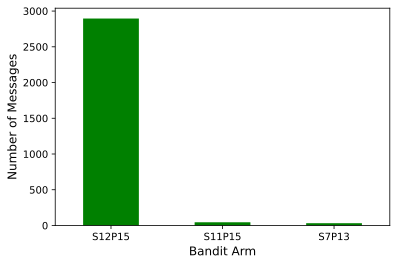

In [11]:
# set_matplotlib_formats('svg')
hist = arms.plot(kind='bar',rot=0, color='g')
hist.set_xlabel("Bandit Arm",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

Export plot to SVG.

In [12]:
hist.get_figure().savefig('adr-bandit-arms.svg', dpi=300)

### Spreading Factor

Text(0, 0.5, 'Number of Messages')

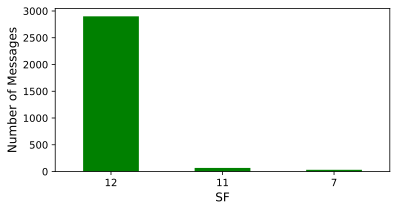

In [13]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='g', figsize=(6,3))
hist.set_xlabel("SF",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [14]:
uplink_frequency = uplink_data.frequency / 1000000

Text(0, 0.5, 'Number of Messages')

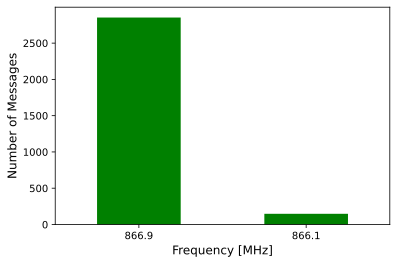

In [15]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='g')
hist.set_xlabel("Frequency [MHz]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

### Duration of Data Transmission

In [16]:
airtime = uplink_data.airtime.value_counts()
threshold = 10
airtime = airtime.loc[lambda x : x > threshold]
print(f'Values with low then {threshold} occurences will be cut from a plot')

Values with low then 10 occurences will be cut from a plot


Text(0, 0.5, 'Number of Messages')

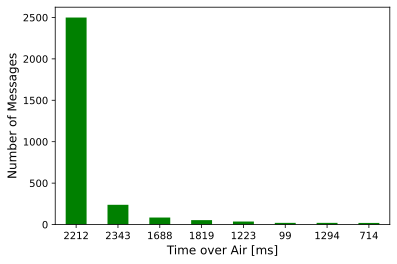

In [17]:
hist = airtime.plot(kind="bar",rot=0,color='g')
hist.set_xlabel("Time over Air [ms]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

In [18]:
hist.get_figure().savefig('adr-airtime.svg', dpi=300)

### Transmission Power

Text(0, 0.5, 'Number of Messages')

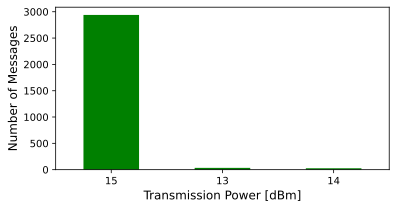

In [19]:
hist = uplink_data.power.value_counts().plot(kind="bar",rot=0,color='g',figsize=(6,3))
hist.set_xlabel("Transmission Power [dBm]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

### Different Types of Messages

Let us analyze the ratio of message types.

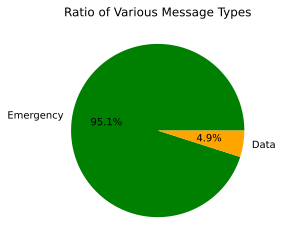

In [20]:
message_types = uplink_data.message_type_id.value_counts()

plt.pie(message_types, autopct='%1.1f%%', labels=['Emergency', 'Data'], colors=['g', 'orange'])
plt.title('Ratio of Various Message Types')
plt.show()

In [21]:
plt.savefig('adr-message-types.svg', dpi=300)

<Figure size 432x288 with 0 Axes>

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [25]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 90.


In [26]:
uplink_data.node_id.describe()

count     3000
unique      90
top       9eTE
freq        75
Name: node_id, dtype: object

In [27]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

In [28]:
print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 90
Total number of connected access points: 1


In [29]:
end_nodes = pd.read_csv('./15/adr - experiment - 15 - 1.csv', delimiter=',')

In [30]:
end_nodes.head()

,dev_id,active_time,uptime,collisions
0,bTFy,1.03,23.59,213
1,W9xS,4.13,23.60,238
2,QQ9W,7.94,23.61,212
3,w8zS,5.16,23.61,228
4,J836,1.03,23.63,204


### Collision histogram

In [31]:
no_collisions = end_nodes.collisions.value_counts()
threshold = statistics.mean(end_nodes.collisions.value_counts()) * 75
print(f'Values below {threshold} will be cut in a plot')

Values below 127.11864406779661 will be cut in a plot


In [32]:
collisions = end_nodes.collisions[end_nodes.collisions > threshold]
collisions.describe()

count    100.000000
mean     211.720000
std       23.087484
min      151.000000
25%      197.000000
50%      214.000000
75%      228.000000
max      258.000000
Name: collisions, dtype: float64

In [33]:
max_collisions = max(collisions)
min_collisions = min(collisions)
range_collisions = max_collisions - min_collisions
increment = math.ceil(range_collisions / 4)

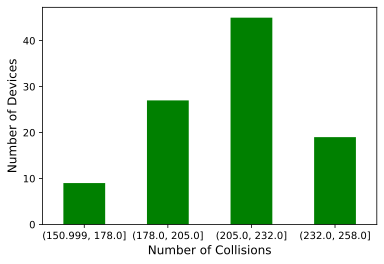

In [34]:
out = pd.cut(collisions, bins=[min_collisions, min_collisions + increment, min_collisions + 2 * increment, min_collisions + 3 * increment, max_collisions], include_lowest=True)
hist = out.value_counts(sort=False).plot.bar(rot=0,color='g')
hist.set_xlabel("Number of Collisions",fontsize=12)
hist.set_ylabel("Number of Devices",fontsize=12)
plt.show()

In [35]:
hist.get_figure().savefig('adr-collisions.svg', dpi=300)

### Ration between active time and total nodes uptime

In [36]:
energy = (end_nodes.active_time / end_nodes.uptime)

In [37]:
active_time = round(statistics.mean(energy) * 100, 2)
print(f'The nodes spent {active_time}% of their uptime in active mode.')

The nodes spent 23.15% of their uptime in active mode.


## Path of Each End Node

Data about position are encoded as base64.

Decode base64, extract position and save the results to original data frame.

In [36]:
try:
    app_data = uplink_data.app_data.apply(base64.b64decode)
    app_data = app_data.astype(str)
    app_data = app_data.str.split(',')

    df = pd.DataFrame({}, columns = ['node_id', 'x', 'y'])

    x = []
    y = []

    for row in app_data:
        x.append(round(float(row[1].split('\'')[0]), 2))
        y.append(round(float(row[0].split('\'')[1]), 2))

    uplink_data['x'] = x
    uplink_data['y'] = y
    
    del uplink_data['app_data']
except KeyError:
    print('Column has already been removed')

In [37]:
uplink_data.head()

,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,message_type_id,ap_id,node_id,arm,x,y
0,2.9,-84.4,36000,1,866100000,7,13,58,1,111111,PHDA,S7P13,6001.7,6999.2
1,7.6,-72.8,36000,1,866900000,12,15,1294,2,111111,NBiG,S12P15,4652.1,6348.0
2,-12.4,-88.8,36000,1,866100000,7,13,58,1,111111,8XwI,S7P13,3163.9,2880.4
3,-11.0,-86.1,36000,1,866100000,7,13,58,1,111111,vmmR,S7P13,2570.9,4828.8
4,-12.2,-92.4,36000,1,866100000,7,13,58,1,111111,DY9f,S7P13,3092.1,2255.7


Now, we draw a path for each end node based on the received coordinates.

(0.0, 10000.0)

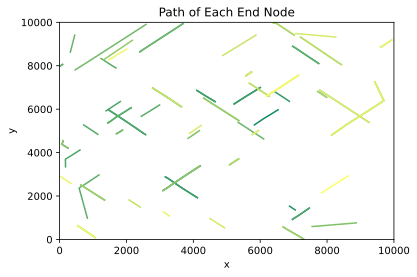

In [38]:
unique_ens = len(uplink_data.node_id.unique())
cmap = mpl.cm.summer

for i in range(0, unique_ens):
    data = uplink_data[uplink_data.node_id == uplink_data.node_id[i]]
    plt.plot(data.x, data.y, color=cmap(i / unique_ens))

plt.title('Path of Each End Node')
plt.ylabel('y')
plt.xlabel('x')

plt.xlim([0,10000])
plt.ylim([0,10000])

In [39]:
plt.savefig('adr-path.svg', dpi=300)

<Figure size 432x288 with 0 Axes>